<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C1/C1.html"><img src="../data/C1_nav.png" width="100"  style="float:right;" alt="C1"></a>
<h1> Timbre</h1>        
</div>

<br />

<p>
Following Section 1.3.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we address aspects of music that are related to timbre.
</p> 

## Basic Definition

Besides pitch, loudness, and duration, there is another fundamental aspect of sound referred to as **timbre** or **tone color**. Timbre allows a listener to distinguish the musical tone of a violin, an oboe, or a trumpet even if the tone is played at the same pitch and with the same loudness. The aspect of timbre is very hard to grasp and subjective. For example, the sound of a musical instrument may be described with such words as bright, dark, warm, harsh, and other terms. Researchers have tried to approach timbre by looking at correlations to more objective sound characteristics such as the temporal and spectral evolution, the absence or presence of tonal and noise-like components, or the energy distribution across the partials of a tone. 

## Envelope and ADSR Model

One sound characteristics that influences the timbre of a sound is the **envelope** of a waveform, which can be regarded to be a smooth curve outlining its extremes in amplitude. In sound synthesis, the envelope of a signal to be generated is often described by a model called **ADSR**, which consists of an attack (A), decay (D), sustain (S), and release (R) phase. The relative durations and the amplitudes of the four phases have a significant impact
on how the synthesized tone will sound. The following figure shows an idealized ADSR model, as well as envelopes of a piano and violin sound (playing a single note C4).

<img src="../data/C1/FMP_C1_F22a-23.png" width="700px" align="middle" alt="C1">

As indicated by the figure, playing a single note already produces a complex sound mixture with characteristics that may constantly change over time, containing periodic as well as nonperiodic components. At the beginning of a musical tone, there is often a sudden increase of energy. In this short phase, the **attack phase** of the tone, the sound builds up. It contains a high degree of nonperiodic components that are spread over the entire range of frequencies. In acoustics, such a noise-like short-duration sound of high amplitude occurring at the beginning of a waveform is also called a **transient**. After the attack phase, the sound of a musical tone stabilizes (**decay phase**) and reaches a steady phase with a (more or less) periodic pattern. This third phase, which is also called the **sustain phase**, makes up most of the duration of a musical tone, where the energy remains more or less constant or slightly decreases as is the case with a piano sound. In the final phase of a musical tone, also called the **release phase**, the musical tone fades away. In the following code cell, we provide a function for generating an idealized ADSR model.

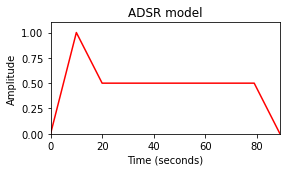

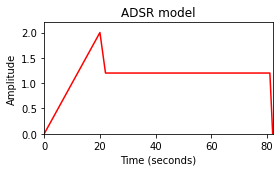

In [1]:
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import os
import sys

sys.path.append('..')
import libfmp.b
import libfmp.c1

%matplotlib inline

def compute_adsr(len_A=10, len_D=10, len_S=60, len_R=10, height_A=1.0, height_S=0.5):
    """Computation of idealized ADSR model

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        len_A (int): Length (samples) of A phase (Default value = 10)
        len_D (int): Length (samples) of D phase (Default value = 10)
        len_S (int): Length (samples) of S phase (Default value = 60)
        len_R (int): Length (samples) of R phase (Default value = 10)
        height_A (float): Height of A phase (Default value = 1.0)
        height_S (float): Height of S phase (Default value = 0.5)

    Returns:
        curve_ADSR (np.ndarray): ADSR model
    """
    curve_A = np.arange(len_A) * height_A / len_A
    curve_D = height_A - np.arange(len_D) * (height_A - height_S) / len_D
    curve_S = np.ones(len_S) * height_S
    curve_R = height_S * (1 - np.arange(1, len_R + 1) / len_R)
    curve_ADSR = np.concatenate((curve_A, curve_D, curve_S, curve_R))
    return curve_ADSR

curve_ADSR = compute_adsr(len_A=10, len_D=10, len_S=60, len_R=10, height_A=1.0, height_S=0.5)

libfmp.b.plot_signal(curve_ADSR, figsize=(4,2.5), ylabel='Amplitude', title='ADSR model', color='red')
plt.show()

curve_ADSR = compute_adsr(len_A=20, len_D=2, len_S=60, len_R=1, height_A=2.0, height_S=1.2)
libfmp.b.plot_signal(curve_ADSR, figsize=(4,2.5), ylabel='Amplitude', title='ADSR model', color='red')
plt.show()

The ADSR model is a strong simplification and only yields a meaningful approximation for amplitude envelopes of tones that are generated by certain instruments. For example, the violin sound as shown above is not approximated well by the ADSR model. First of all, since the tone is played softly with a gradual increase in volume, the attack phase is spread out in time. Furthermore, there does not seem to be any decay phase and the subsequent sustain phase is not steady; instead, the amplitude envelope oscillates in a regular fashion. The release phase starts when the violinist stops exciting the string with the bow. The sound then quickly fades out. 

## Envelope Computation

There are many ways to compute an envelope of a waveform. In the following, we use a simple sliding windowing approach by applying a maximum filter over each windowed section. In the following code cell, we provide an implementation for computing an upper envelope and a lower envelope of a given waveform as well as an envelope of the waveform's magnitude. The result is shown for the piano and violin sound (playing a single note C4) already used in the figure above.

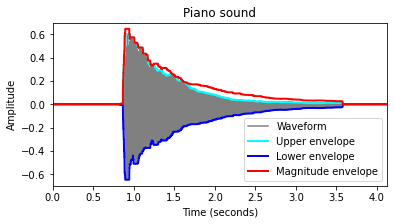

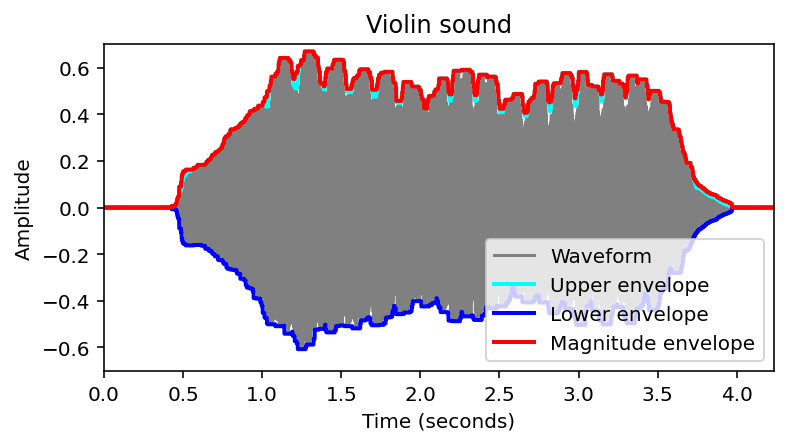

In [2]:
def compute_envelope(x, win_len_sec=0.01, Fs=4000):
    """Computation of a signal's envelopes

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        win_len_sec (float): Length (seconds) of the window (Default value = 0.01)
        Fs (scalar): Sampling rate (Default value = 4000)

    Returns:
        env (np.ndarray): Magnitude envelope
        env_upper (np.ndarray): Upper envelope
        env_lower (np.ndarray): Lower envelope
    """
    win_len_half = round(win_len_sec * Fs * 0.5)
    N = x.shape[0]
    env = np.zeros(N)
    env_upper = np.zeros(N)
    env_lower = np.zeros(N)
    for i in range(N):
        i_start = max(0, i - win_len_half)
        i_end = min(N, i + win_len_half)
        env[i] = np.amax(np.abs(x)[i_start:i_end])
        env_upper[i] = np.amax(x[i_start:i_end])
        env_lower[i] = np.amin(x[i_start:i_end])
    return env, env_upper, env_lower
    
def compute_plot_envelope(x, win_len_sec, Fs, figsize=(6, 3), title=''):
    """Computation and subsequent plotting of a signal's envelope

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        x (np.ndarray): Signal (waveform) to be analyzed
        win_len_sec (float): Length (seconds) of the window
        Fs (scalar): Sampling rate
        figsize (tuple): Size of the figure (Default value = (6, 3))
        title (str): Title of the figure (Default value = '')

    Returns:
        fig (mpl.figure.Figure): Generated figure
    """
    t = np.arange(x.size)/Fs
    env, env_upper, env_lower = compute_envelope(x, win_len_sec=win_len_sec, Fs=Fs)
    fig = plt.figure(figsize=figsize)
    plt.plot(t, x, color='gray', label='Waveform')
    plt.plot(t, env_upper, linewidth=2, color='cyan', label='Upper envelope')
    plt.plot(t, env_lower, linewidth=2, color='blue', label='Lower envelope')
    plt.plot(t, env, linewidth=2, color='red', label='Magnitude envelope')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t[0], t[-1]])
    plt.ylim([-0.7, 0.7])
    plt.legend(loc='lower right')
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))
    return fig
    
Fs = 11025
win_len_sec=0.05

fn_wav = os.path.join('..', 'data', 'C1', 'FMP_C1_F23_Piano.wav')
x, Fs = librosa.load(fn_wav, sr=Fs)
fig = compute_plot_envelope(x, win_len_sec=win_len_sec, Fs=Fs, title='Piano sound')

fn_wav = os.path.join('..', 'data', 'C1', 'FMP_C1_F23_Violin.wav')
x, Fs = librosa.load(fn_wav, sr=Fs)
fig = compute_plot_envelope(x, win_len_sec=win_len_sec, Fs=Fs, title='Violin sound')

## Vibrato and Tremolo

The violin example indicates other phenomena that are relevant for timbre. For example, one can observe periodic variations in amplitude. Such amplitude modulations are also known as **tremolo**. The effect of tremolo often goes along with **vibrato**, which is a musical effect consisting of a regular, pulsating change of frequency (frequency modulations). Besides string music, vibrato is mainly used by human singers to add expression. Even though tremolo and vibrato are simply local changes in  intensity and frequency, they do not necessarily evoke a perceived change in loudness or pitch of the overall musical tone. Rather, they are features that influence the timbre of a musical tone.

In the following code cell, we generate a simple sinusoid, a sinusoid with vibrato, as well as a sinusoid with tremolo. 

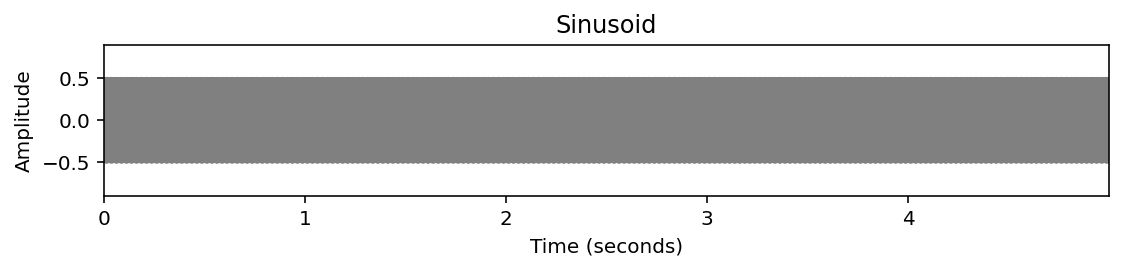

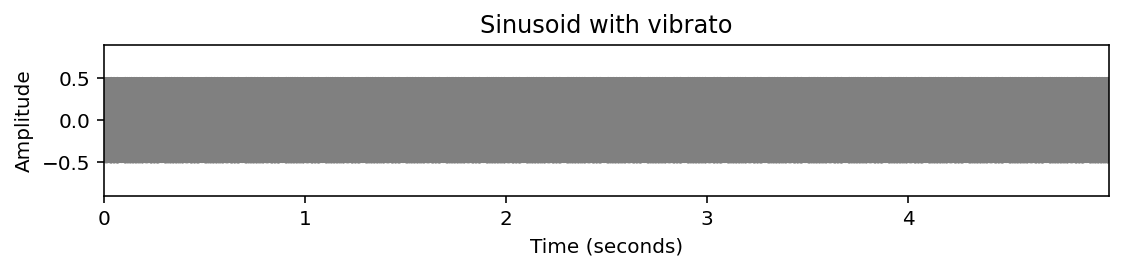

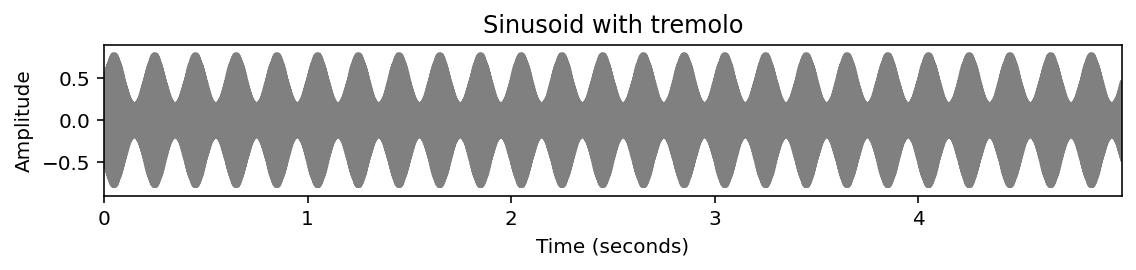

In [3]:
def generate_sinusoid_vibrato(dur=5, Fs=1000, amp=0.5, freq=440, vib_amp=1, vib_rate=5):
    """Generation of a sinusoid signal with vibrato

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        dur (float): Duration (in seconds) (Default value = 5)
        Fs (scalar): Sampling rate (Default value = 1000)
        amp (float): Amplitude of sinusoid (Default value = 0.5)
        freq (float): Frequency (Hz) of sinusoid (Default value = 440)
        vib_amp (float): Amplitude (Hz) of the frequency oscillation (Default value = 1)
        vib_rate (float): Rate (Hz) of the frequency oscillation (Default value = 5)

    Returns:
        x (np.ndarray): Generated signal
        t (np.ndarray): Time axis (in seconds)

    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    freq_vib = freq + vib_amp * np.sin(t * 2 * np.pi * vib_rate)
    phase_vib = np.zeros(num_samples)
    for i in range(1, num_samples):
        phase_vib[i] = phase_vib[i-1] + 2 * np.pi * freq_vib[i-1] / Fs
    x = amp * np.sin(phase_vib)
    return x, t

def generate_sinusoid_tremolo(dur=5, Fs=1000, amp=0.5, freq=440, trem_amp=0.1, trem_rate=5):
    """Generation of a sinusoid signal with tremolo

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        dur (float): Duration (in seconds) (Default value = 5)
        Fs (scalar): Sampling rate (Default value = 1000)
        amp (float): Amplitude of sinusoid (Default value = 0.5)
        freq (float): Frequency (Hz) of sinusoid (Default value = 440)
        trem_amp (float): Amplitude of the amplitude oscillation (Default value = 0.1)
        trem_rate (float): Rate (Hz) of the amplitude oscillation (Default value = 5)

    Returns:
        x (np.ndarray): Generated signal
        t (np.ndarray): Time axis (in seconds)
    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    amps = amp + trem_amp * np.sin(t * 2 * np.pi * trem_rate)
    x = amps * np.sin(2*np.pi*(freq*t))
    return x, t

Fs = 4000
dur = 5
freq = 220
amp = 0.5
figsize = (8,2)

x, t = libfmp.c1.generate_sinusoid(dur=dur, Fs=Fs, amp=amp, freq=freq)
x_vib, t = generate_sinusoid_vibrato(dur=dur, Fs=Fs, amp=amp, freq=freq, vib_amp=6, vib_rate=5)
x_trem, t = generate_sinusoid_tremolo(dur=dur, Fs=Fs, amp=amp, freq=freq, trem_amp=0.3, trem_rate=5)

libfmp.b.plot_signal(x, Fs=Fs, figsize=figsize, ylabel='Amplitude', title='Sinusoid')
plt.ylim([-0.9, 0.9])
plt.show()
ipd.display(ipd.Audio(data=x, rate=Fs))

libfmp.b.plot_signal(x_vib, Fs=Fs, figsize=figsize, ylabel='Amplitude', title='Sinusoid with vibrato')
plt.ylim([-0.9, 0.9])
plt.show()
ipd.display(ipd.Audio(data=x_vib, rate=Fs))

libfmp.b.plot_signal(x_trem, Fs=Fs, figsize=figsize, ylabel='Amplitude', title='Sinusoid with tremolo')
plt.ylim([-0.9, 0.9])
plt.show()
ipd.display(ipd.Audio(data=x_trem, rate=Fs))

## Partials 

Perhaps the most important and well-known property for characterizing timbre is the existence of certain partials and their relative strengths. Intuitively, **partials** are the dominant frequencies of a musical tone with the lowest partial being the **fundamental frequency**. The inharmonicity expresses the extent to which a partial deviates from the closest ideal harmonic. For harmonic sounds such as a musical tone with a clearly perceivable pitch, most of the partials are close to being harmonics. However, not all partials need to occur with the same strength. The following figure shows spectrogram representations for a single note C4 played on different instruments. 

<div>
<img src="../data/C1/FMP_C1_F23_FourInstruments.png" width="800px" alt="C1" style="margin-left:0px">
</div>


<div>
<audio src="../data/C1/FMP_C1_F23_Piano.wav" type="audio/mpeg" controls="controls" style="width: 190px;"></audio>
<audio src="../data/C1/FMP_C1_F23_Trumpet.wav" type="audio/mpeg" controls="controls" style="width: 190px;"></audio>
<audio src="../data/C1/FMP_C1_F23_Violin.wav" type="audio/mpeg" controls="controls" style="width: 190px;"></audio>
<audio src="../data/C1/FMP_C1_F23_Flute.wav" type="audio/mpeg" controls="controls" style="width: 190px;"></audio>
</div>

Both the fundamental frequency of the note (261.6 Hz) as well as its harmonics (integer multiples of 261.6 Hz) are visible as horizontal structures. The decay of the musical tone is reflected by a corresponding decay in each of the partials. Most of the tone's energy is contained in the lower partials, and the energy tends to be lower for the higher partials. Such a distribution is typical for many instruments. For string instruments, sounds tend to have a rich spectrum of partials, where lots energy may also be contained in the upper harmonics. The figure also reveals the tremolo (in particular for the flute) and the vibrato (in particular for the violin).

## Missing Fundamental

As said before, the timbre of a sound crucially depends on the signal's energy distribution across the harmonics. Also, the perception of the perceived pitch depends not only on the fundamental frequency, but also on its higher harmonics and their relationships. For example, a human may perceive the pitch of a tone even if the fundamental frequency associated to this pitch is completely missing. This phenomenon is known as **missing fundamental**. 

In the following code example, we generate a sound by adding up (weighted) sinusoids with frequencies that are integer multiples of a note's center frequency. In particular, we generate a pure tone (with MIDI pitch $p$), a tone with harmonics, a tone with harmonic with missing fundamental, and a pure tone (with MIDI pitch $p+12$).

Pure tone (p = 60):


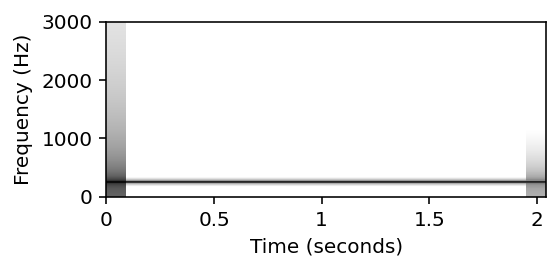

Tone with harmonics (p = 60):


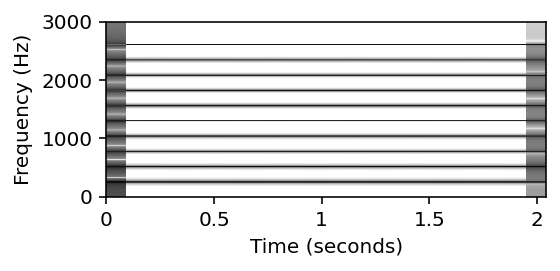

Tone with harmonics and missing fundamental (p = 60):


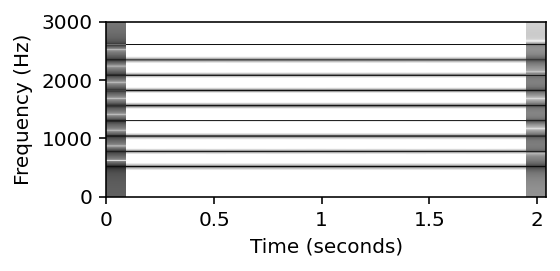

Pure tone (p = 72):


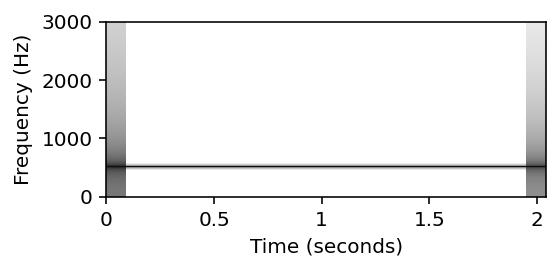

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
%matplotlib inline

def generate_tone(p=60, weight_harmonic=np.ones([16, 1]), Fs=11025, dur=2):
    """Generation of a tone with harmonics

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        p (float): MIDI pitch of the tone (Default value = 60)
        weight_harmonic (np.ndarray): Weights for the different harmonics (Default value = np.ones([16, 1])
        Fs (scalar): Sampling frequency (Default value = 11025)
        dur (float): Duration (seconds) of the signal (Default value = 2)

    Returns:
        x (np.ndarray): Generated signal
        t (np.ndarray): Time axis (in seconds)
    """
    freq = 2 ** ((p - 69) / 12) * 440
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = np.zeros(t.shape)
    for h, w in enumerate(weight_harmonic):
        x = x + w * np.sin(2 * np.pi * freq * (h + 1) * t)
    return x, t

def plot_spectrogram(x, Fs=11025, N=4096, H=2048, figsize=(4, 2)):
    """Computation and subsequent plotting of the spectrogram of a signal

    Notebook: C1/C1S3_Timbre.ipynb

    Args:
        x: Signal (waveform) to be analyzed
        Fs: Sampling rate (Default value = 11025)
        N: FFT length (Default value = 4096)
        H: Hopsize (Default value = 2048)
        figsize: Size of the figure (Default value = (4, 2))

    """
    N, H = 2048, 1024
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.abs(X)
    plt.figure(figsize=figsize)
    librosa.display.specshow(librosa.amplitude_to_db(Y, ref=np.max),
                             y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap='gray_r')
    plt.ylim([0, 3000])
    # plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

Fs = 11025
p = 60

print('Pure tone (p = %s):' % p)
x, t = generate_tone(Fs=Fs, p=p, weight_harmonic=[0.2])
plot_spectrogram(x)
ipd.display(ipd.Audio(data=x, rate=Fs))

print('Tone with harmonics (p = %s):' % p)
x, t = generate_tone(Fs=Fs, p=p, weight_harmonic=[0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
plot_spectrogram(x)
ipd.display(ipd.Audio(data=x, rate=Fs))

print('Tone with harmonics and missing fundamental (p = %s):'  % p)
x, t = generate_tone(Fs=Fs, p=p, weight_harmonic=[0, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
plot_spectrogram(x)
ipd.display(ipd.Audio(data=x, rate=Fs))

print('Pure tone (p = %s):' % (p + 12))
x, t = generate_tone(Fs=Fs, p=p, weight_harmonic=[0, 0.2])
plot_spectrogram(x)
ipd.display(ipd.Audio(data=x, rate=Fs))

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Tim Zunner.
</div>

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>